In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [8]:
import visdom
vis = visdom.Visdom()

### Logging callbacks

In [3]:
class GradLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern, debug_print=False):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        self.debug_print = debug_print
        
    def on_grad_computed(self, net, named_parameters, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), named_parameters)
        for name, param in param_pairs:
            history_name = 'grad_' + name
            net.history.record_batch(history_name, param.grad.abs().mean().item())
            self.to_accumulate_.add(history_name)
            if self.debug_print:
                print(param.grad.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)

In [4]:
class ParamLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        
    def on_batch_end(self, net, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            history_name = 'mean_' + name
            net.history.record_batch(history_name, param.mean().item())
            self.to_accumulate_.add(history_name)
            #print(param.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)

In [5]:
class ParamPrinter(skorch.callbacks.Callback):
    def __init__(self, param_pattern, mode='batch', format='{}'):
        self.param_pattern = param_pattern
        self.mode = mode
        self.format = format
        
    def print_params(self, net):
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            print([self.format.format(n) for n in param.data.tolist()])
        
    def on_batch_end(self, net, **kwargs):        
        if self.mode != 'batch':
            return
        self.print_params(net)
            
    def on_epoch_end(self, net, **kwargs):
        if self.mode != 'epoch':
            return
        self.print_params(net)   

### Modules

In [17]:
class GaussClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', 
                 non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.m = nn.Parameter(torch.ones(hidden_dim) - 0.5)
        self.s = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        torch.nn.init.uniform_(self.m.data, 0, 1)
        torch.nn.init.uniform_(self.s.data, 0.01, 0.1)
        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        clks = torch.randn(x.size(1), self.hidden_dim).to(x)
        clks = F.sigmoid(clks * self.s + self.m)

        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = clks[ti]
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y = clock_gate * self.act(h_new) + (1 - clock_gate) * h
                h = y
            else:
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [7]:
class IRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', 
                 non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim #+ 1
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        ys = []
        cs = []
        for ti in range(x.size(1)):
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y =  self.act(h_new)
                h = y
            else:
                h = h_new
                y = self.act(h)
            ys.append(y)
            cs.append(y)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

### Data creation

In [9]:
def get_batch(batch_size, time_steps, random_state=0):
    """Generate the adding problem dataset"""
    rng = np.random.RandomState(seed=random_state)
    
    # Build the first sequence
    add_values = rng.rand(batch_size, time_steps)
    add_values = add_values.astype('float32')

    # Build the second sequence with one 1 in each half and 0s otherwise
    add_indices = np.zeros_like(add_values)
    half = int(time_steps / 2)
    for i in range(batch_size):
        first_half = rng.randint(half)
        second_half = rng.randint(half, time_steps)
        add_indices[i, [first_half, second_half]] = 1

    # Zip the values and indices in a third dimension:
    # inputs has the shape (batch_size, time_steps, 2)
    inputs = np.dstack((add_values, add_indices))
    targets = np.sum(np.multiply(add_values, add_indices), axis=1)
    return inputs, targets.reshape(-1, 1)

In [10]:
class AddDataset(torch.utils.data.Dataset):
    def __init__(self, n_timesteps, length=200, random_state=0):
        self.n_timesteps = n_timesteps
        self.length = length
        self.rng_ = np.random.RandomState(seed=random_state)
    def __getitem__(self, i):
        Xi, yi = get_batch(1, self.n_timesteps, random_state=self.rng_.randint(1e8))
        return Xi[0], yi[0]
    def __len__(self):
        return self.length

In [11]:
T = 100
dataset_train = AddDataset(n_timesteps=T, length=200)
X_valid, y_valid = get_batch(200, T, random_state=1)

### Task Model

In [13]:
class AdditionModel(nn.Module):
    def __init__(self, num_hidden=64, act='relu', num_layers=1, visdom=False, 
                 rnn_type='gauss', non_linear_state=False):
        super().__init__()
        
        self.visdom = visdom
        self.rnn = []
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        for i in range(num_layers):
            input_dim = 2 if i == 0 else num_hidden
            output_dim = num_hidden
            if rnn_type == 'gauss':
                self.rnn.append(GaussClocking(input_dim, output_dim, 
                                              act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'irnn':
                self.rnn.append(IRNN(input_dim, output_dim, 
                                     act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'gru':
                self.rnn.append(nn.GRU(input_dim, output_dim, batch_first=True))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        self.cis = [None] * self.num_layers
        for i in range(self.num_layers):
            if self.rnn_type == 'gru':
                li, hi = self.rnn[i](li)
                ci = None
            else:
                li, hi, ci = self.rnn[i](li)
            self.cis[i] = ci
            if self.visdom:
                vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
                if ci is not None:
                    vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clocks rnn'+str(i)}, win="clocks rnn"+str(i))
        return self.clf(li[:, -1])

In [73]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss, # ignored, we overwrite get_loss
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        return (y_pred - y_true).abs().mean(-1).mean()

In [74]:
torch.manual_seed(1333)

def my_train_split(ds, y):
    return ds, skorch.dataset.Dataset(X_valid, y_valid)

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.RMSprop,
             lr=0.002,
             max_epochs=300,
             train_split=my_train_split,
             
             module__num_hidden=50,
             module__act='relu',
             module__num_layers=1,
             module__visdom=False,
             module__rnn_type='gauss',
             module__non_linear_state=True,
             
             #iterator_train=train_iterator,
             #iterator_train__n_batches=200,
             #iterator_train__n_timesteps=100,
             #iterator_train__shuffle=True,
             
             device='cpu',
             batch_size=16,
            
             optimizer__param_groups=[
                 ('rnn*.m', {'lr': 0.02}),
                 #('rnn*.m', {'lr': 0.2}),
                 #('rnn*.s', {'lr': 0.02}),
             ],
             
             callbacks=[
                 #skorch.callbacks.ProgressBar(),
                 #('mae_valid', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_valid', lower_is_better=False)),
                 #('mae_train', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_train', lower_is_better=False, on_train=True)),
                 ('grad_log_1', GradLogger('rnn*.i2h.weight')),
                 ('grad_log_2', GradLogger('rnn*.h2h.*')),
                 ('grad_log_3', GradLogger('rnn*.[ms]')),
                 #('parm_log_1', ParamPrinter('rnn*.m', mode='epoch', format='{:.3f}')),
                 skorch.callbacks.GradientNormClipping(gradient_clip_value=10),
             ]
            )

In [75]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.h2h.weight    grad_rnn0.i2h.weight    grad_rnn0.m    grad_rnn0.s     train_loss    valid_loss     dur
-------  ----------------------  ----------------------  -------------  -------------  -------------  ------------  ------
      1            7373480.0933            3203366.3826   2500016.0212    181686.6360  19691838.7392        0.6418  0.7198
      2                  0.0180                  0.0442         0.0020         0.0002        0.4056        0.3563  0.7526
      3                  0.0079                  0.0197         0.0008         0.0001        0.3623        0.3414  0.7024
      4                  0.0108                  0.0257         0.0012         0.0002        0.3557        0.3408  0.7939
      5                  0.0101                  0.0248         0.0011         0.0002        0.4065        0.3471  0.7431
      6                  0.0061                  0.0180         0.0006         0.0001        0.3457   

     65                  0.0016                  0.0057         0.0004         0.0001        0.3399        0.3495  0.8603
     66                  0.0027                  0.0086         0.0006         0.0001        0.3213        0.3454  0.8701
     67                  0.0021                  0.0070         0.0005         0.0001        0.3404        0.3415  0.9907
     68                  0.0019                  0.0063         0.0004         0.0001        0.3201        0.4009  0.8941
     69                  0.0021                  0.0070         0.0005         0.0001        0.3362        0.3414  0.6807
     70                  0.0017                  0.0062         0.0004         0.0001        0.3452        0.3432  0.7522
     71                  0.0023                  0.0080         0.0006         0.0001        0.3373        0.3423  0.7462
     72                  0.0020                  0.0073         0.0005         0.0001        0.3392        0.3469  0.8161
     73                 

    132                  0.0022                  0.0107         0.0007         0.0002        0.3577        0.3325  0.7572
    133                  0.0017                  0.0078         0.0006         0.0003        0.3196        0.3202  0.7551
    134                  0.0025                  0.0107         0.0008         0.0003        0.3336        0.3363  0.7280
    135                  0.0019                  0.0088         0.0007         0.0002        0.3499        0.3225  0.6874
    136                  0.0026                  0.0122         0.0009         0.0004        0.3348        0.3253  0.7494
    137                  0.0065                  0.0267         0.0021         0.0009        0.3229        0.3440  0.7583
    138                  0.0014                  0.0072         0.0006         0.0002        0.3215        0.3285  0.9449
    139                  0.0016                  0.0083         0.0007         0.0003        0.3135        0.3245  1.1391
    140                 

    198                  0.0064                  0.0529         0.0035         0.0010        0.1673        0.2664  0.9747
    199                  0.0099                  0.0882         0.0060         0.0011        0.1754        0.1922  0.9252
    200                  0.0079                  0.0675         0.0051         0.0009        0.1704        0.1612  0.8209
    201                  0.0055                  0.0463         0.0039         0.0008        0.1535        0.1571  0.7755
    202                  0.0056                  0.0495         0.0036         0.0009        0.1664        0.1549  0.6944
    203                  0.0067                  0.0562         0.0032         0.0009        0.1551        0.1487  0.7081
    204                  0.0082                  0.0685         0.0053         0.0015        0.1611        0.1785  0.8033
    205                  0.0066                  0.0553         0.0035         0.0010        0.1704        0.1347  0.8593
    206                 

    264                  0.0122                  0.1285         0.0085         0.0009        0.1183        0.1086  0.7017
    265                  0.0105                  0.1123         0.0071         0.0012        0.1081        0.0912  0.7305
    266                  0.0128                  0.1397         0.0093         0.0013        0.1119        0.0939  0.7402
    267                  0.0086                  0.0967         0.0063         0.0010        0.1012        0.0740  0.7514
    268                  0.0115                  0.1212         0.0086         0.0013        0.1152        0.1110  0.7624
    269                  0.0101                  0.1083         0.0073         0.0011        0.1017        0.1100  0.7494
    270                  0.0120                  0.1248         0.0077         0.0012        0.1011        0.1102  0.7234
    271                  0.0126                  0.1422         0.0084         0.0009        0.1148        0.1020  0.7248
    272                 

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GaussClocking(
      (i2h): Linear(in_features=2, out_features=50, bias=True)
      (h2h): Linear(in_features=50, out_features=50, bias=False)
      (act): ReLU()
    )
    (clf): Linear(in_features=50, out_features=1, bias=True)
  ),
)

### Look at clocks from last validation run

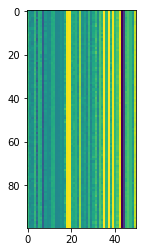

In [76]:
plt.imshow(ef.module_.cis[0].data.numpy());

Take a look at the 'clocking' for unit 0 - 9 over time:

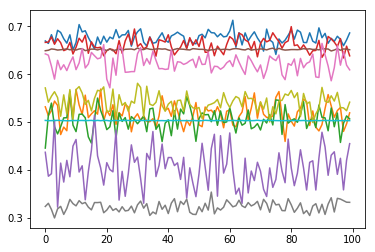

In [77]:
[plt.plot(ef.module_.cis[0].data.numpy()[:, n]) for n in range(10)];

Distribution of 'clocks' (mean values of Gaussians):

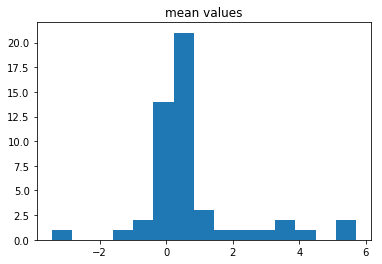

In [78]:
plt.hist(ef.module_.rnn[0].m.data.numpy(), bins=15);
plt.title('mean values');

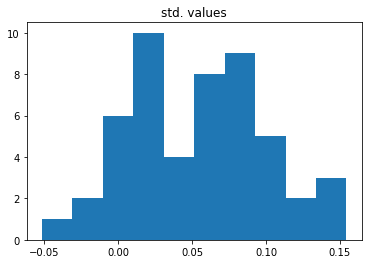

In [79]:
plt.hist(ef.module_.rnn[0].s.data.numpy(), bins=10);
plt.title('std. values');

### History of gradients during training

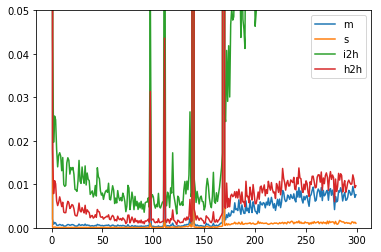

In [80]:
plt.plot(ef.history[:, 'grad_rnn0.m'])
plt.plot(ef.history[:, 'grad_rnn0.s'])
plt.plot(ef.history[:, 'grad_rnn0.i2h.weight']) # weights input -> hidden
plt.plot(ef.history[:, 'grad_rnn0.h2h.weight']) # weights hidden -> hidden
plt.legend(['m', 's', 'i2h', 'h2h'])
plt.ylim([0, .05]);

### Loss over time

(0, 1)

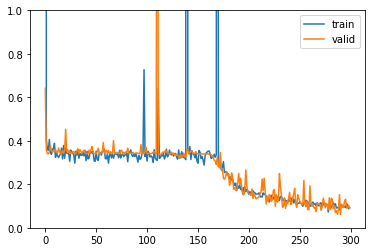

In [81]:
plt.plot(ef.history[:, 'train_loss'])
plt.plot(ef.history[:, 'valid_loss'])
plt.legend(['train', 'valid'])
plt.ylim([0, 1])